In [47]:
import numpy as np
import os
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob
import re
import imutils
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import collections
from skimage.draw import circle, line
from skimage.measure import regionprops
import tqdm
import matplotlib.image as mpimg
import shutil

In [48]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# the GPU id to use (0, 1, 2 or 3)
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [49]:
def atoi(text):
   return int(text) if text.isdigit() else text
def natural_keys(text):
   return [atoi(c) for c in re.split('(\d+)', text)]


In [50]:
via = '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/well_C7_img_video/'
directory = os.mkdir(via) 

In [51]:
p = '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/'
directory = os.mkdir(p) 

In [52]:
path = '/mnt/holomonitor-pvc/project/gpcr/Storage/P010721/'
image_list = []
for dirname, dirnames,filenames in os.walk(path):
    for filename in sorted(filenames, key = natural_keys):
        if 'C7-1' in filename:

            im=cv2.imread(path + filename)

            shutil.copy(path+filename, p + '/' + filename)

            image_list.append(im)
            

In [53]:
len(image_list)

82

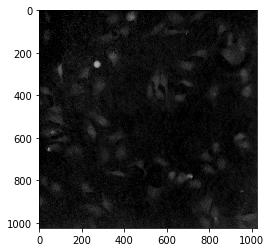

In [54]:
plt.imshow(image_list[2])

In [55]:
i_0 = image_list[0]


In [56]:
d = {}
    
cx = []
cy = []

shifted = cv2.pyrMeanShiftFiltering(i_0, 10, 51)
gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
    
    

for label in np.unique(labels):
    if label == 0:
        continue


        
        
    mask = np.zeros(gray.shape, dtype='uint8')
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(c)
        
        
        
    cx.append(int(x))
    cy.append(int(y))
        

    data = {'X':cx,'Y':cy}
        
    data = pd.DataFrame(data)

    
d = data

In [57]:
len(d)

77

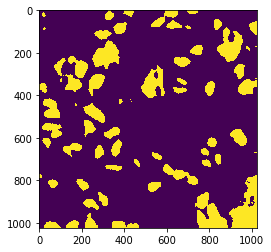

In [58]:
plt.imshow(thresh)

In [59]:
coords = d.values.tolist()


In [60]:
def generateMask(img, circle_ratio=10, background_ratio=8): #10 and 8 standaard
    # ratio = size of seed to make around annotation
    # ratio is for the mask edge which is set to not object
    # for the watershed grow out from the seed and in from the edge
    size = img.shape[0], img.shape[1]

    xc, yc = int(size[0] / 2), int(size[1] / 2)

    markers = np.zeros([img.shape[0], img.shape[1]], dtype=np.int32)

    # set object seed #
    # markers[xc - 2:xc + 2, yc - 2:yc + 2] = 2

    rr, cc = circle(xc, yc, circle_ratio, img.shape)
    markers[rr, cc] = 2

    # set backgound seed #

    markers[0:int(size[0] / background_ratio), 0:size[1]] = 1

    markers[int(size[0] * (background_ratio - 1) / background_ratio):size[0], 0:size[1]] = 1

    markers[0:size[0], 0:int(size[0] / background_ratio)] = 1

    markers[0:size[0], int(size[1] * (background_ratio - 1) / background_ratio):size[1]] = 1

    return markers

In [61]:
def extract_new_centroid(crop, shape, coords):
    mask = generateMask(crop, circle_ratio=10, background_ratio=8) #10 and 8 standaard
    ret_mask = mask.copy()

    img_rgb = cv2.cvtColor(((crop / np.max(crop)) * 255).astype('uint8'), cv2.COLOR_GRAY2RGB)

    cv2.watershed(img_rgb, mask)
    mask[mask != 2] = 0
    mask[mask == 2] = 1

    m = np.zeros(shape, dtype='uint8')

    m[np.maximum(coords[1] - offset, 0):np.minimum(coords[1] + offset, shape[0]),
    np.maximum(coords[0] - offset, 0):np.minimum(coords[0] + offset, shape[1])] = mask

    rprop = regionprops(m)

    c = rprop[0].centroid

    return c, mask, ret_mask


In [62]:
f = (glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/*.tiff'))

files = sorted(f, key=natural_keys)

In [63]:
files

['/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 1.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 2.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 3.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 4.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 5.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 6.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 7.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 8.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 9.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 10.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 11.tiff',
 '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/Well C7-1 12.tiff',
 

In [64]:
all_coords = []

offset = 32 # distance out from center so with 100 gives 200x200 box

for cell_nr in tqdm.tqdm(range(len(coords) - 1)):

    cell_coords = []

    im = cv2.imread(files[0], -1)

    path = np.zeros(im.shape, dtype='uint8')

    crop = im[np.maximum(coords[cell_nr][1] - offset,0):np.minimum(coords[cell_nr][1] + offset,im.shape[0]),
            np.maximum(coords[cell_nr][0] - offset,0):np.minimum(coords[cell_nr][0] + offset,im.shape[1])]

    c, mask, ret_mask = extract_new_centroid(crop, im.shape, coords[cell_nr])

    rr, cc = line(coords[cell_nr][1], coords[cell_nr][0], int(round(c[0])), int(round(c[1])))
    path[rr, cc] = 16000 # number could be anything

    coord = np.round(c).astype('int')[::-1]

    for file in files[1:]:
        im = cv2.imread(file, -1)

        crop = im[np.maximum(coord[1] - offset, 0):np.minimum(coord[1] + offset, im.shape[0]),
                np.maximum(coord[0] - offset, 0):np.minimum(coord[0] + offset, im.shape[1])]

        c, mask, ret_mask = extract_new_centroid(crop, im.shape, coord)

        rr, cc = line(coord[1], coord[0], int(round(c[0])), int(round(c[1])))
        path[rr, cc] = 16000

            # im[path != 0] = 16000
            # plt.imshow(crop)
            # plt.imshow(ret_mask, alpha = 0.5)
            # plt.show(block=False)
            # plt.pause(0.001)
            # plt.close()
            # plt.subplot(121), plt.imshow(crop), plt.imshow(mask, alpha=0.4)
            # plt.subplot(122), plt.imshow(crop), plt.imshow(ret_mask, alpha=0.4)
            # plt.show()

        coord = np.round(c).astype('int')[::-1]

        cell_coords.append(list(coord))

    all_coords.append(cell_coords)


100%|██████████| 76/76 [02:55<00:00,  2.31s/it]


In [65]:
df = pd.DataFrame(all_coords)


In [66]:
l=list(df.columns)
len(l)

81

In [67]:
for ix, i in tqdm.tqdm(enumerate(l)):

    d_1 = df.iloc[:,ix]



    df3 = d_1.apply(pd.Series)
    df3.columns = ['X', 'Y']

    image_list = []
    for filename in sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/C7_img/*.tiff'), key=natural_keys): 
        im=cv2.imread(filename)

        image_list.append(im)

    image = image_list[ix]

    x = []
    y = []

    for i in range(len(df3)):
        x.append(df3.iloc[i,0])
        y.append(df3.iloc[i,1])



    for idx, i in enumerate(x):



        cv2.circle(image, (x[idx], y[idx]), 3, (0, 255, 255), -1)
        cv2.putText(image, "{0}".format(idx), (x[idx] - 20, y[idx] - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    #plt.imshow(image)



    im = Image.fromarray(image)
    im.save("/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/well_C7_img_video/image_{0}.tiff".format(ix))

81it [02:19,  1.72s/it]


In [68]:
image_folder = '/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/well_C7_img_video/'
video_name = 'video_cell_wellC7.avi'

images = [img for img in sorted(os.listdir(image_folder), key=natural_keys) if img.endswith(".tiff")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

error: OpenCV(4.1.2) /io/opencv/modules/highgui/src/window.cpp:645: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
